*Group 2: Fabiana Caccavale, Martina Manno, Matteo Gioia, Vincenzo J. Striano, Marco Vita Antonio, Marco Pisano.*

# Ethics for AI project: Understanding biases in AI-based financial services

**Libraries with fixed versions and data loading**

In [ ]:
!conda install --yes python==3.7.10
!conda install --yes xgboost==1.6.2
!conda install --yes shap==0.41.0
!conda install --yes pandas==1.3.5
!conda install --yes plotly==5.10.0
!conda install --yes scikit-learn==1.0.2
!conda install --yes matplotlib
!conda install --yes seaborn
!conda install --yes dython

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import shap
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import dython

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from dython.nominal import associations

In [2]:
# # Enable export of plotly interactivity in html export
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected = True)

The project (https://www.kaggle.com/c/home-credit-default-risk) is based on a kaggle competition concerning the  potential benefits and risks analysis of entrusting the choice of granting a loan to an AI model.

The dataset to be worked on is the "application train" and in particular 26 columns (1 target, 1 ID and 24 features) were selected from a total of 122 in order to have a more interpretable view.

In [69]:
ap_train = pd.read_csv('application_train.csv',
                    usecols =  ['TARGET', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
                                'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
                                'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE',
                                'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 
                                'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 
                                'EXT_SOURCE_2', 'EXT_SOURCE_3'])
print(f"Application train dataset shape: {ap_train.shape}")

Application train dataset shape: (307511, 26)


To make the DAYS_BIRTH variable more intuitive, it was transformed in AGE.

In [70]:
ap_train['AGE'] = -round(ap_train['DAYS_BIRTH']/365)
ap_train.drop(columns='DAYS_BIRTH', inplace=True)

# [#1] Interesting variables
*The first step is to reflect on which variables might be prone to an ethical discussion.*

In anti-discrimination philosophy, Cass Sunstein writes, “without good reason, social and legal structures should not turn differences that are both highly visible and irrelevant from the moral point of view into systematic social disadvantages”(Sunstein 1994).
Algorithmic-related bias refers to systematic and repeatable errors in a mathematical
or computer system that lead to ‘unfair’ outputs, privileging one or more groups over
others.
We identified 15 variables prone to ethical discussion that we do not consider relevant in judging, automated or otherwise, an individual's creditworthiness with respect to a mortgage. 


- **CODE_GENDER**: results in ethical relevance because an individual's gender should not be a useful variable in the choice of granting a mortgage (Men vs. Women, Men vs. Transgender)

- **FLAG_OWN_CAR**: results in ethical relevance because the ownership of a car does not affect the choice of granting a mortgage. Owning or not owning a car does not turn out to be related to a customer's creditworthiness. It is more than plausible, that individuals living in a large city prefer to use public or sustainable transportation. 



- **FLAG_OWN_REALTY**: home ownership does not affect the choice of granting a mortgage. Owning or not owning a car does not appear to be related to a client's creditworthiness. Although home ownership is commonly associated with large economic capacity, statistics show that in countries with higher GDP, the percentage of individuals owning a home for residential use decreases. For example, Romania does not rank as a high-income economy within the European Union, has the highest homeownership rates in the EU, and has the most crowded housing. Romania has 96.4 percent of its population owning homes. 

- **CNT_CHILDREN**: turns out to be of ethical relevance because the number of children does not affect the choice to grant a mortgage. There is a tendency to think that a large number of children results in large expenses that decrease the ability to repay the debt. First, relying only on the number of offspring does not indicate how many more of the children are dependent on the individual; they may already be financially independent. Moreover, it is incorrect not to take into consideration that a possible partner might contribute to the expenses of supporting the offspring. Therefore, we believe that other variables should also be taken into consideration. 

- **NAME_TYPE_SUITE**: who accompanies the borrower should not be considered in the granting of a mortgage. The one who should be solvent is the one who makes the commitment. The judgment cannot be influenced by the accompanying person under any circumstances. The judgment must be based on the borrower. 

- **NAME_INCOME_TYPE**: This variable is prone to ethical discourse in part. It is not fair to make a judgment about solvency between an individual state servant and a commercial associate or pensioner for example. In both cases, value should not bias the judgment and thus is of ethical relevance. However, in this variable we also find the unemployment factor, which in our view cannot be considered ethically relevant. The fact that an individual is unemployed is a strong factor that should condition the individual's judgment of insolvency. The fact that an individual does not have a fixed salary and therefore economic insecurity in theory should be a very relevant factor for the bank.  

- **NAME_EDUCATION_TYPE**: turns out to be ethically relevant because the level of education should not be taken into consideration in the granting of a mortgage (Although a high level of education may indicate possible higher earnings, it still does not ensure economic stability or a lower level of education does not undermine an individual's creditworthiness).

- **OCCUPATION_TYPE**:  The type of occupation is not an accurate index of income. Even in the same category of occupation there can be a huge income gap. A chef in a starred restaurant will not have the same income as a chef in a chain restaurant. 

- **NAME_FAMILY_STATUS**: turns out to be ethically relevant because family status should not be taken into consideration when granting a mortgage. The number of individuals in the family does not ensure greater economic availability. Two married individuals might still have less aggregate income than a single individual or a widow.

- **NAME_HOUSING_TYPE**: The type of property should not be taken into consideration when granting a mortgage. Home ownership does not indicate greater economic availability and vice versa. Young people might be discriminated against because, especially in italy, it is not common to own a home. Those who travel a lot and therefore have economic availability may not have home ownership.

- **REGION_POPULATION_RELATIVE**: We consider it of ethical relevance as well as absolute irrelevance toward judgment since a highly populated region is not an indication of wealth or poverty (Rio de Janeiro vs. New York City). Judging also on the basis of regional population may be unnecessary as well as incorrect. 

- **DAYS_BIRTH**: this variable discriminates young people because they are considered less creditworthy or the elderly because they are subject to lower life expectancy.

- **DAYS_EMPLOYED**: it is not necessarily the case that someone who is a new employee has a lower salary, and therefore potentially less creditworthy, or that someone who has been employed for a long time has more disposable income.

- **DAYS_ID_PUBLISH**: this variable is more important for a discourse of verifying the identity of the individual and thus in the validity of the loan issuance rather than the solvency of the individual. 

- **OWN_CAR_AGE**: The age of a car cannot be an indication of the individual's solvency. A dated car might be worth more than a new car, and an individual might keep a car as a matter of affection, and this is not an indication of the individual's poverty or wealth.

# [#2] Interesting variables with respect to target
*The second step concerns the understanding of the ethical variables highlited with respect to the target variable.*


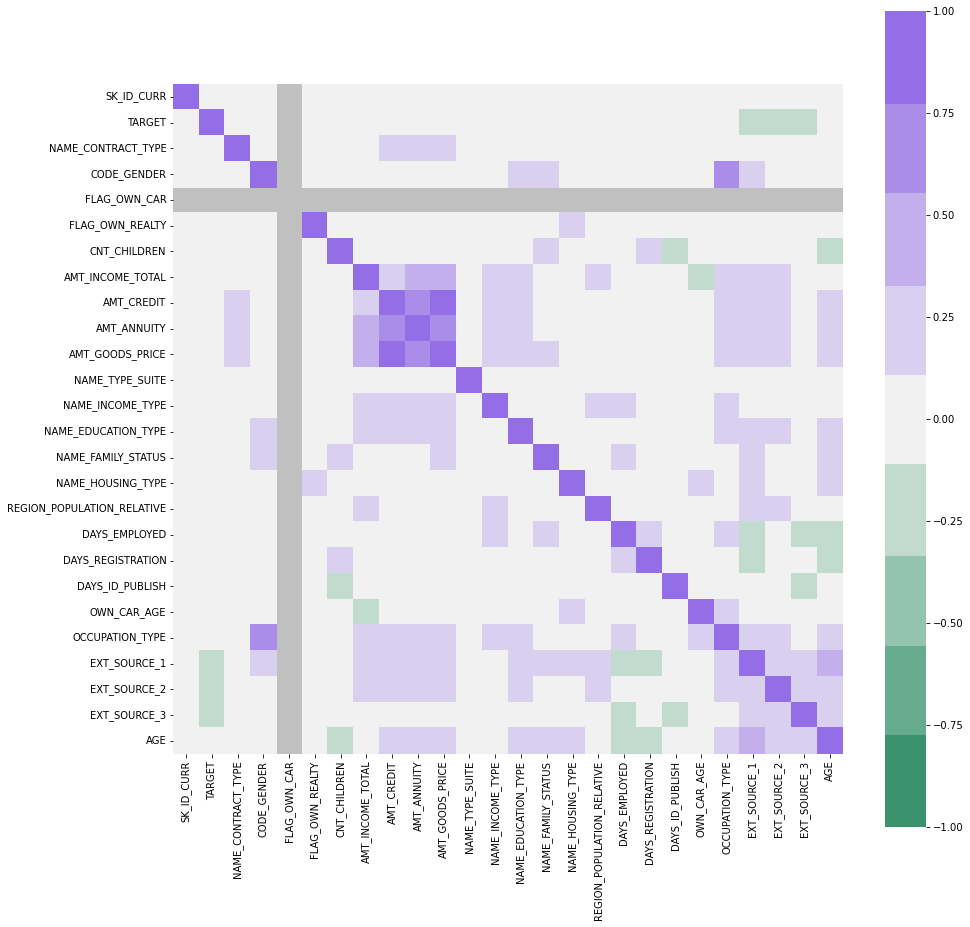

In [6]:
complete_correlation= associations(ap_train, figsize=(15,15), nan_strategy = 'drop_samples', vmin=-1, vmax=1,
                                   cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9), annot=False)

The target variable appears to be not correlated with any of the other dataset's variables. There is only a slight negative correlation with the variables EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3 (at which the correlation is respectively of -0.14, -0.14 and -0.17).So, a possible interpretation is that clients who have a low external source score would be inclined to be in the target number 1, then in the group of clients with some payment difficulties. However, since it is not known whether the normalized score from external data source to which these variables refer to has an ethical nature or not, it is not possible to determine whether these variables have ethical relevance.

**TARGET**

In [ ]:
ap_train.groupby('TARGET').apply(len)

In [ ]:
fig = px.histogram(ap_train, color="TARGET", x="TARGET", barmode="group")
fig.show()

The target is a binary variable with no missing values. It can assume the value 1 whether the client has payment difficulties (such as late payment more than X days on at least one of the first Y installments of the loan); or 0 in all other cases. 
The overall number of client is about 307.511 and the graph above shows that only 24.825 clients (the 8% over the total) has been categorized among those who have payment difficulties.

**CODE_GENDER**

In [7]:
ap_train.groupby('CODE_GENDER').apply(len)

CODE_GENDER
F      202448
M      105059
XNA         4
dtype: int64

In [8]:
fig = px.histogram(ap_train, color="TARGET", x="CODE_GENDER", barmode="group")
fig.show()

The variable indicates the gender of the client applying for the loan. The sample is made up of 2/3 women.  
Out of the total number of clients there are 4 who preferred not to declare their gender, this could be due to a random reason or because it might be perceived as sensible data. Moreover, this variable can be consider prone to ethical discussion because gender, whether male or female, should have no influence on the solvency of the client, as the results in graph above show. Hence, it cannot in any way be generalise that women or men are more or less solvent.

**FLAG_OWN_CAR**

In [ ]:
ap_train.groupby('FLAG_OWN_CAR').apply(len)

In [ ]:
fig = px.histogram(ap_train, color="TARGET", x="FLAG_OWN_CAR", barmode="group")
fig.show()

The binary variable indicates whether the client owns a car or not. Out of the total number of clients, the 65% declare to not own a car. This variable is not relevant with regard to the solvency of clients because, as shown in the graph, among those who not own a car the 8% have payment difficulties but also among those who own a car the 7% has solvency problems.

**FLAG_OWN_REALTY**

In [ ]:
ap_train.groupby('FLAG_OWN_REALTY').apply(len)

In [ ]:
fig = px.histogram(ap_train, color="TARGET", x="FLAG_OWN_REALTY", barmode="group")
fig.show()

The binary variable indicates whether the client owns a house or flat or not. Out of the total number of clients, the 70% declare to own a house/flat. The graph above shows that this variable is quite irrelevant concerning solvency of clients. Infact among those who own realty the 8% have payment difficulties and also among those who not own realty the 8% have payment difficulties. 

**CNT_CHILDREN**

In [ ]:
ap_train.groupby('CNT_CHILDREN').apply(len)

In [ ]:
ap_train['CNT_CHILDREN'].describe()

In [ ]:
fig = px.histogram(ap_train, color="TARGET", x="CNT_CHILDREN", barmode="group", log_y = True)
fig.show()

The variable represents the number of children the client applying for the loan has. The number of children goes from 0 to 19. 
There are 215.371 over 307.511 clients who declare that they do not have children. Among those who don't have children the 92% are solvent clients. Among clients who have from 1 to 6 children at least the 70% are solvent clients.
What is evident is that there are some clients who have 7,8,10,12,14,19 children who are all among solvent clients but they are only 18 over the total amount of clients. On the other hand, clients who have 9 and 11 children are all with payment difficulties but they are overall only 3 clients. 
It is possible to conclude that clients who have 0 or at least 1 children represents the 75% of the overall amount of clients and respectively the 92% and 91% of them are solvent. 

**NAME_TYPE_SUITE**

In [ ]:
ap_train['NAME_TYPE_SUITE'].isnull().sum() 

In [ ]:
ap_train.groupby('NAME_TYPE_SUITE').apply(len)

In [ ]:
fig = px.histogram(ap_train, color="TARGET", x="NAME_TYPE_SUITE", barmode="group")
fig.show()

The variable indicates who was accompanying client when applying for the loan. There are 1292 missing values which refers to clients who choose not to declare who they are accompanied by. The most frequent type of this variable is "unaccompanied" which cover more or less the 80% of cases. As shown by the graph above, there is not a category that has an influence on the target variable, infact all of them has at least 90% of solvent clients. 

**NAME_INCOME_TYPE**

In [ ]:
ap_train.groupby('NAME_INCOME_TYPE').apply(len)

In [ ]:
fig = px.histogram(ap_train, color="TARGET", x="NAME_INCOME_TYPE", barmode="group", log_y=True)
fig.show()

The variable indicates the source of the client's income:
- Working (51% of clients)
- Commercial associate (23% of clients)
- Pensioner (18% of clients)
- State servant (7% of clients)
- Student
- Maternity leave
- Business man
- Unemployed

The most frequent source of the client's income is a general working, the other main categories of income are made up of commercial associate, state servant and pensioner. The last 1% of income type derives from student, business man, people who perceived maternity leave and people unemployed. In this case what we expect is fulfilled  because students, unemployed persons, businessman and women in maternity hardly have access to a loan for diametrically opposite reasons. For example, a student or an unemployed person will not apply for a loan because they are unlikely to be granted one and on the other hand, a businessman should not need a loan. One interesting thing that emerges from the graph is that both students and businesses have no problems paying their loans. Whereas, the 30%-40% of unemployed and women with maternity leave have payment difficulties. 

**NAME_EDUCATION_TYPE**

In [ ]:
ap_train.groupby('NAME_EDUCATION_TYPE').apply(len)

In [ ]:
fig = px.histogram(ap_train, color="TARGET", x="NAME_EDUCATION_TYPE", barmode="group", log_y=True)
fig.show()

The variable indicates the level of highest education the client achieved which can be categorized in:
- Secondary/Secondary special
- Higher education
- Incomplete higher
- Lower secondary
- Academic degree.

The 71% of clients has a secondary level of education and 91% of them are solvent. All these categories report at least the 89% of solvent clients. Therefore, this variable is not relevant to highlited clients categories in terms of solvency. 

**OCCUPATION_TYPE**

In [ ]:
ap_train['OCCUPATION_TYPE'].isnull().sum() 

In [ ]:
ap_train.groupby('OCCUPATION_TYPE').apply(len)

In [ ]:
fig = px.histogram(ap_train, x="OCCUPATION_TYPE", color="TARGET", barmode="group", log_y=True)
fig.show()

The variable indicates what kind of occupation does the client have in the moment applying for the loan. It reports that there are 96391 missing values which not to correspond to those who had declared to be unemployed because the number was significantly lower (22 clients). So, one should reflect on why the 31% of clients preferred to not state their work. This could be related to the fact that there is no a category in which customers can express "other" types of work or it could be due to the fact that clients do not feel comfortable in expressing their job. Concerning the target variable, all these categories report at least the 82% of solvent clients, so there is no evidence that belonging to a certain job category affects the client's solvency.

**NAME_FAMILY_TYPE**

In [ ]:
ap_train.groupby('NAME_FAMILY_STATUS').apply(len)

In [ ]:
fig = px.histogram(ap_train, color="TARGET", x="NAME_FAMILY_STATUS", barmode="group", log_y=True)
fig.show()

The variable represents the family status of the client. It must be considered taht there are 2 different categories for people married: one is related to civil marriage, so the other will probably refer to a religious marriage. Belong to the latter category, 63% of clients. Regarding the relation to the target variable, at least the 90% in each category has no payment difficulties, so it is not possible to say that this variable indicates the client solvency.

**NAME_HOUSING_TYPE**

In [ ]:
ap_train.groupby('NAME_HOUSING_TYPE').apply(len)

In [ ]:
fig = px.histogram(ap_train, color="TARGET", x="NAME_HOUSING_TYPE", barmode="group", log_y=True)
fig.show()

The variable indicates what is the housing situation of the client:
- House/apartment
- Rented apartment
- With parents
- Municipal apartment
- Office apartment
- Co-op apartment

The 88% of clients results to have a house or apartment, among these only the 8% have some payment difficulties. With respect to the target variable, the graph shows that the 12% of people who have rented apartment and the 11% who live with parents have some payments difficulties, but they are only few cases over the overall number of clients.

**REGION_POPULATION_RELATIVE**

In [ ]:
ap_train['REGION_POPULATION_RELATIVE'].describe()

In [ ]:
fig = px.histogram(ap_train, x="REGION_POPULATION_RELATIVE", color="TARGET", range_x=[0, 0.079], histnorm='percent')
fig.show()

The variable is a normalized population of region where client lives. It can assume values from 0.000290 to 0.072508: higher number means the client lives in more populated region. The graph shows that most clients live in sparsely populated regions. 

**DAYS_BIRTH**

In [ ]:
ap_train['AGE'].min()

In [ ]:
ap_train['AGE'].max()

In [ ]:
fig = px.histogram(ap_train, x="AGE", color="TARGET", barmode="group")
fig.show()

The variable reports the age of clients which range goes from 21 to 69. As expected, on the overall the variable has no implication on the target, but obviously the people with the most payments difficulties in are the younger ones.

**DAYS_EMPLOYED**

In [ ]:
ap_train['DAYS_EMPLOYED']

In [ ]:
year_employed = ap_train['DAYS_EMPLOYED']//365
year_employed.max()

In [ ]:
year_employed.describe()

In [ ]:
fig = px.histogram(ap_train, x="DAYS_EMPLOYED", color="TARGET")
fig.show()

The variable describes how many days before the application the person started current employment. As already analyzed most of the client are employed. However, it should be noted that there are a lot of negative values  of which we do not know the correct interpretation and then the values goes up to more than 350k days. The interpretation is not straightforward, even trying to transofrm days in years the results do not change so much: the minimum value is always negative (-50) and the maximum is very high (1000) so it doesn't reflect the reality.

**DAYS_ID_PUBLISH**

In [ ]:
ap_train.groupby('DAYS_ID_PUBLISH').apply(len)

In [ ]:
fig = px.histogram(ap_train, x="DAYS_ID_PUBLISH", color="TARGET", barmode="group" )
fig.show()

The variable indicate how many days before the application did client change the identity document with which he applied for the loan. The variable interpretation is not straightforward because there are most negative values.




**OWN_CAR_AGE**

In [ ]:
ap_train['OWN_CAR_AGE'].isnull().sum() 

In [ ]:
ap_train.groupby('OWN_CAR_AGE').apply(len)

In [ ]:
fig = px.histogram(ap_train, x="OWN_CAR_AGE", color="TARGET", barmode="group" )
fig.show()

The variable indicates the age of client's car. The car age rage goes from 0 to 91. Further, the 65% of the values (202929) are missing. This is coherent with what discovered in the analysis of clients who own a car, in which the results shows that 202924 clients do not have a car. So, there are only 5 missing values related to the car age. With respect to the target variable, it is not a meaningful variable because an old age car can be vintage or second-hand.

# Preparing the data

In order to prepare data for an ML model, the first step is the encoding of features.

In [71]:
ap_train['CODE_GENDER_M'] = np.select([ap_train['CODE_GENDER'] == 'M', ap_train['CODE_GENDER'] == 'F'], [1, 0], default=np.NaN)
ap_train['FLAG_OWN_CAR'] = np.where(ap_train['FLAG_OWN_CAR'] == 'Y', 1, 0)
ap_train['FLAG_OWN_REALTY'] = np.where(ap_train['FLAG_OWN_REALTY'] == 'Y', 1, 0)
ap_train.drop(columns='CODE_GENDER', inplace=True)

In [72]:
ap_objects = list(ap_train.select_dtypes(include=['object']).columns)
ap_train[ap_objects] = ap_train[ap_objects].astype('category')

Separate the target from the rest of the data.

In [73]:
ap_train_target = ap_train.pop('TARGET')
print(f"Target dataset shape: {ap_train_target.shape}")

Target dataset shape: (307511,)


Split the original dataset into 2 datasets:

*   80% for the train set
*   20% for the validation set, which will correspond to the test set of the project



In [74]:
df_train, df_test, df_target_train, df_target_test = train_test_split(
    ap_train, ap_train_target, test_size=0.2, stratify=ap_train_target, random_state=42)

print(f"Train dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")

Train dataset shape: (246008, 25)
Test dataset shape: (61503, 25)


# Create a basic ML model and scoring on the test set

The model performed is a XGBoost whose parameters were chosen beforehand by cross-validation.  

In [100]:
df_train_dmatrix = xgb.DMatrix(df_train.drop(columns='SK_ID_CURR'), df_target_train, enable_categorical=True)

param = {'max_depth': 6,
         'eta': .2,
         'subsample': .9,
         'colsample_bytree': .9,
         'scale_pos_weight': 10,
         'objective': 'binary:logistic',
         'tree_method': 'exact'}

xgb_base_model = xgb.train(param, df_train_dmatrix, num_boost_round=50)

Score the test set:

In [101]:
df_test_dmatrix = xgb.DMatrix(df_test.drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results = xgb_base_model.predict(df_test_dmatrix)

- What are the risk scores (from 0 to 1) of the first 5 customers in the test set? And what's the overall AUC on the test set?

In [102]:
df_test.iloc[:5,:]

SK_ID_CURR NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
256571      396899         Cash loans             1                1   
191493      322041         Cash loans             0                0   
103497      220127         Cash loans             0                1   
130646      251531         Cash loans             0                0   
211898      345558         Cash loans             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
256571             1          157500.0    770292.0      30676.5   
191493             0           90000.0    364896.0      19926.0   
103497             0          148500.0    284400.0      18643.5   
130646             0          188100.0    976711.5      38218.5   
211898             0          180000.0    323194.5      19660.5   

        AMT_GOODS_PRICE NAME_TYPE_SUITE  ... DAYS_EMPLOYED DAYS_REGISTRATION  \
256571         688500.0          Family  ...          -105           -2876.0   
191493         315000.0          Family  ...         -4930           -4654.0   
103497         225000.0   Unaccompanied  ...         -1191          -12511.0   
130646         873000.0   Unaccompanied  ...          -355            -969.0   
211898         279000.0   Unaccompanied  ...         -1366          -10063.0   

       DAYS_ID_PUBLISH OWN_CAR_AGE  OCCUPATION_TYPE  EXT_SOURCE_1  \
256571           -4402        19.0         Laborers           NaN   
191493           -1259         NaN         Laborers      0.593554   
103497           -2474         NaN   Security staff           NaN   
130646           -2289         NaN       Core staff      0.628656   
211898           -1040         NaN         Laborers           NaN   

        EXT_SOURCE_2  EXT_SOURCE_3   AGE CODE_GENDER_M  
256571      0.594327      0.427657  37.0           1.0  
191493      0.619621      0.484851  49.0           0.0  
103497      0.030108      0.538863  66.0           1.0  
130646      0.417593      0.411849  26.0           0.0  
211898      0.355126      0.593718  48.0           0.0  

[5 rows x 25 columns]

In [103]:
xgb_base_test_results[:5]

array([0.45560062, 0.23749042, 0.7490776 , 0.24548666, 0.49250585],
      dtype=float32)

The risk scores are between the 0.24 and 0.75 for the first 5 customers in the test set.

In [106]:
fpr, tpr, thresholds = metrics.roc_curve(df_target_test, xgb_base_test_results, pos_label=1)
benchm_auc = metrics.auc(fpr, tpr)
print(benchm_auc)

0.7541543982734993


0.75 is the probability that the classifier correctly ranks a random client among those who are solvent or who have payment difficulties. 

# **[#3] Evaluating feature importance**
*The third step is to understand whether the ethical variables highlited are actually important in the runned model*
#### **[#3.1] Evaluating feature importance using built-in xgboost plot_importance**

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

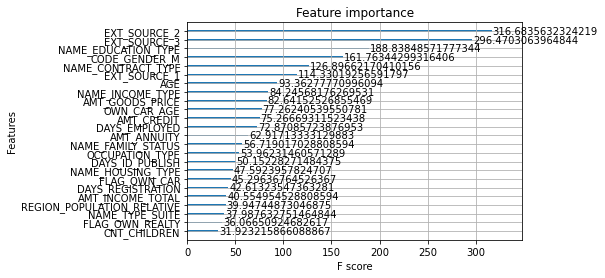

In [18]:
xgb.plot_importance(xgb_base_model, importance_type='gain')

# The Gain is the most relevant attribute to interpret the relative importance of each feature.
# ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. The idea is that before adding a new split on a feature X to the branch there was some wrongly classified elements, after adding the split on this feature, there are two new branches, and each of these branch is more accurate

#### **[#3.2] Evaluating feature importance using SHAP plot_importance**
*[Interpretation](https://blog.datascienceheroes.com/how-to-interpret-shap-values-in-r/)*

#To have a clearer interpretation of the categorical variables in this approach, it is necessary to transform them into dummies.

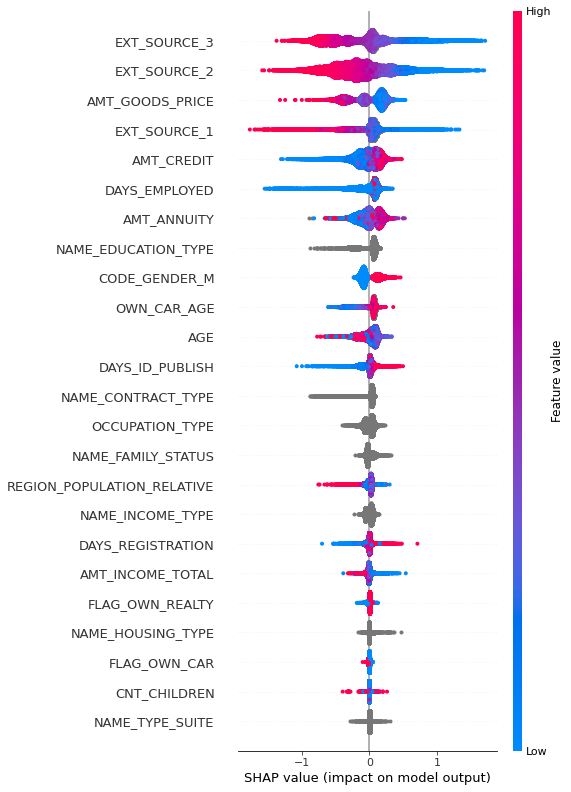

In [19]:
def shap_eval():
    max_disp = df_test.shape[1]
    explainer = shap.TreeExplainer(xgb_base_model)
    shap_values = explainer.shap_values(df_test_dmatrix)
    shap.summary_plot(shap_values, df_test.iloc[:,1:], max_display = max_disp)
shap_eval()

The feature importance of the variables is computed with 2 techniques because the first method focus on the relation between the variable and the prediction, whereas the SHAP values calculate the importance of a feature by comparing what a model predicts with and without the feature and since the order in which a model sees features can affect its predictions, this is done in every possible order, so that the features are fairly compared. The shap values on the x-axis, so from this is possible to extract the probability of success. Whereas, the gradient color indicates the original value for that variable, for example it is grey for categorical variable such as in case of the name education type, it is 2 colors whether the variable is binary such as in the case of gender. 

The approach to this task is to take in consideration both models, the first in terms of order importance and the second to have a clearer interpretation.
Both models highlighted that the 2 most relevannt variables are external sources (EXT_SOURCE_3 and EXT_SOURCE_2) whose information are not known but it is possible to say that they have more total model impact than the EXT_SOURCE_1 which affects few predictions by a large amount. On the other hand, one of the least relevant variable seems to be the number of children the loan applicant has.

Regarding the ethical variable previously disccussed, those that appear to have the most impact on the model output are: 
- the level of education which impact is mostly positive on the model, but there are few predictions affected by a large negative amount.
- the gender of the clients that in the few cases of men has a positive effect on th model, whereas the women density is bigger and so the total model impact is more and negative. 
- the age of the client seems to have few high age cases with a highly negative impact on the model, and more your age cases with a slightly positive effect on the model.
- the number of days before the loan request the client started current employment are mostly low values which affects few predictions by a large negative amount.
- the own car age appears to have more high values which has a lightly positive effect on the model, and few low values which affect negatively more the model predictions. 
- the number of days before the loan request the client change is ID. In this case there are few low values which affect strongly negative the model and more high values which has a slight positive effect on the model.
- region population relative. In this case there are few region with high population concentration which negative effect on the model is strong, and more clients who live in low population region which effect is lightly positive on the model.

# **[#4] Comparing the model predictions with respect to the original training data**
*The fourth step concerns the analysis of the realtion between the predictions and the ethical features with respect to what was bring out in the second task.*
#### **[#4.1] Manual correlation matrix after one hot encoding**

In [20]:
df_test2 = df_test.copy()
df_test2.reset_index(drop = True, inplace = True)

xgb_base_test_results = pd.DataFrame(xgb_base_test_results, columns = ['pred'])

test_correlation = pd.concat([df_test2, xgb_base_test_results],
                             axis = 1)

test_correlation_dummies = pd.get_dummies(test_correlation)

fig = px.imshow(test_correlation_dummies.corr())
fig.show()

#### [#4.2] Correlation matrix using Dython

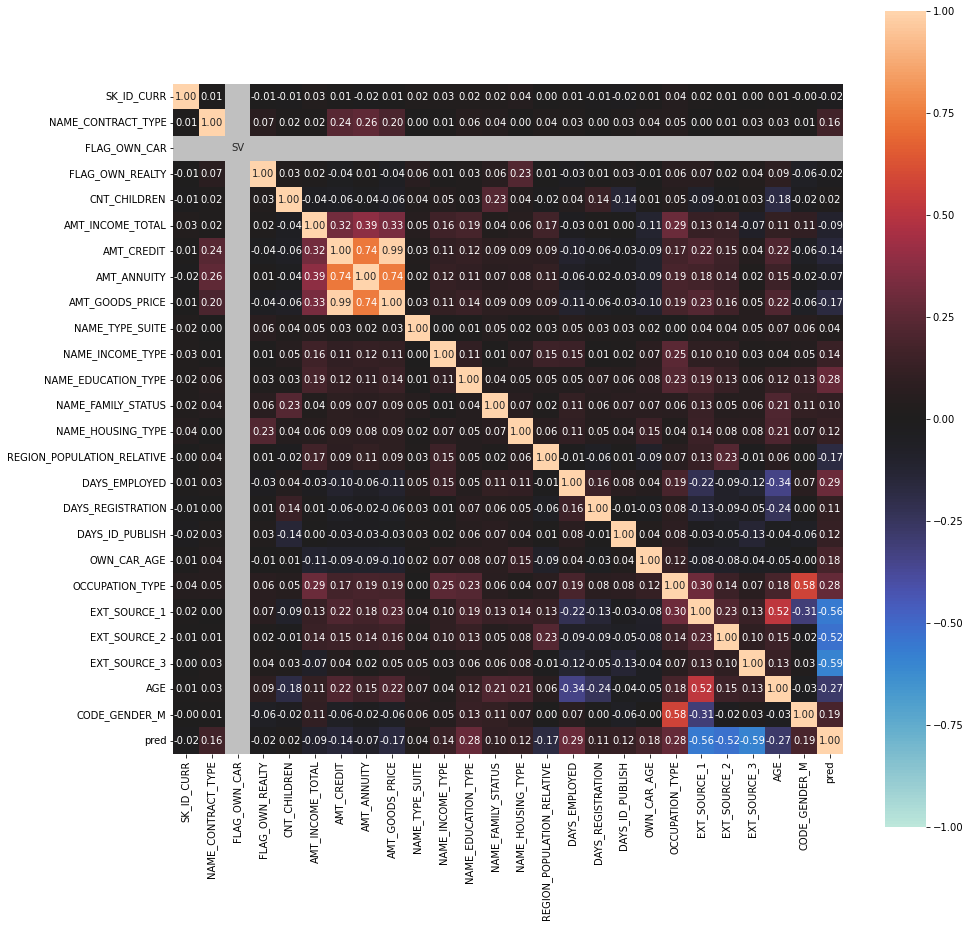

In [21]:
complete_correlation = associations(test_correlation, nan_strategy = 'drop_samples', figsize=(15, 15))

In [22]:
df_test2['TARGET'] = df_target_test
fig = px.histogram(df_test2, color="TARGET", x="CODE_GENDER_M", barmode="group")
fig.show()
fig = px.histogram(df_test2, color="TARGET", x="FLAG_OWN_CAR", barmode="group")
fig.show()
fig = px.histogram(df_test2, color="TARGET", x="FLAG_OWN_REALTY", barmode="group")
fig.show()
fig = px.histogram(df_test2, color="TARGET", x="CNT_CHILDREN", barmode="group", log_y = True)
fig.show()
fig = px.histogram(df_test2, color="TARGET", x="NAME_TYPE_SUITE", barmode="group")
fig.show()
fig = px.histogram(ap_train, color="TARGET", x="NAME_INCOME_TYPE", barmode="group", log_y=True)
fig.show()
fig = px.histogram(df_test2, color="TARGET", x="NAME_EDUCATION_TYPE", barmode="group", log_y=True)
fig.show()
fig = px.histogram(df_test2, x="OCCUPATION_TYPE", color="TARGET", barmode="group", log_y=True)
fig.show()
fig = px.histogram(df_test2, color="TARGET", x="NAME_FAMILY_STATUS", barmode="group", log_y=True)
fig.show()
fig = px.histogram(df_test2, color="TARGET", x="NAME_HOUSING_TYPE", barmode="group", log_y=True)
fig.show()
fig = px.histogram(df_test2, x="REGION_POPULATION_RELATIVE", color="TARGET", range_x=[0, 0.079], histnorm='percent')
fig.show()
fig = px.histogram(df_test2, x="AGE", color="TARGET", barmode="group")
fig.show()
fig = px.histogram(df_test2, x="DAYS_EMPLOYED", color="TARGET")
fig.show()
fig = px.histogram(df_test2, x="DAYS_ID_PUBLISH", color="TARGET", barmode="group" )
fig.show()
fig = px.histogram(df_test2, x="OWN_CAR_AGE", color="TARGET", barmode="group" )
fig.show()

ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AGE', 'CODE_GENDER_M'] but received: TARGET

Regarding the ethical variable highlited in the previous tasks, the overall behaviour between test features and test predictions provided by the ML model remained overall unchanged compared to that found before. This is coherent with what expected because the model has a relatively high AUC (0.75) and therefore the most test predictions are close to reality. 

By looking at the correlation matrixes, the negative correlation between the predicted values and the external sources is stronger than the one originally seen. 

Regarding the ethical variables, stand out that there is a slight positive correlation (0.28) between the predictions and the education level variable, that was not so evident before. And the same is for the days before the application the person started the current employment and the occupation type (respectively 0.29 and 0.28). 

Other slight positive correlations erase with the status of the family, the type of house, the number of days before the clients change ID, and the own car age (respectively 0.10, 0.12, 0.12, 0.18).

Also some slight negative correlations erase with the age and region population relative variables (respectively -0.27 and -0.17). 



# [#5] Alter ethical variables
*The fifth step consist of manually altering some records and find out how model performance changes. The alteration is first computed on the numerical variables, altered all together and individually, then on the categorical variables altered individually and all together.*

### Numerical variables:

In [23]:
variables = ['CNT_CHILDREN', 'REGION_POPULATION_RELATIVE' , 'AGE', 'DAYS_EMPLOYED', 
             'DAYS_ID_PUBLISH', 'OWN_CAR_AGE']

def plot_difference(option):
    # option argument could be "singularly" or "together"

    # Defining the "fitting" function, which will repeat in any cases and return the results dictionary
    def fitting():

        # Fit the model and predict
        df_test_dmatrix_mod = xgb.DMatrix(df_test_mod.drop(columns='SK_ID_CURR'),
                                          enable_categorical=True)

        xgb_base_test_results_mod = xgb_base_model.predict(df_test_dmatrix_mod)

        # Store the percentual change in the results dictionary and transform it to a dataframe
        results[change] = metrics.roc_auc_score(df_target_test[:number], xgb_base_test_results_mod)

        results[change] = ((results[change] - benchmark) / benchmark) * 100

        return results

    # Define the number of samples taken as subset of test set
    number = 30

    # Calculate the benchmark performance
    benchmark = metrics.roc_auc_score(df_target_test[:number], xgb_base_test_results[:number])

    if option == 'together':

        # Create a dictionary to store the changes
        results = dict()

        # Iterate over 0 to 100%, with 10% steps
        for change in np.arange(0, 2, 0.1):

            # Take a subset of the test set
            df_test_mod = df_test.iloc[:number, :].copy(deep=True)

            # For each column in the dataset
            for var in df_test_mod:
                # If the column is in the variables we chose:
                if var in variables:
                    # Change the column by the given change
                    df_test_mod[var] = df_test_mod[var] * change

            results = fitting()

        df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['difference'])

    elif option == 'singularly':

        # Define an empty dataset
        df = pd.DataFrame()

        # Iterate over each variable
        for var in variables:

            # Stores the results in a dictionary
            results = dict()

            #For each number in [0%;200%] with 10% step
            for change in np.arange(0, 2, 0.1):

                # Get the copy of the dataset with a length == number
                df_test_mod = df_test.iloc[:number,:].copy(deep = True)

                # Change the column by the given step
                df_test_mod[var] = df_test_mod[var] * change

                results = fitting()

            # Create a temporary dataframe, which has as index the steps and the column is the variable name; the cell is the relative change in the metrics
            temp_df = pd.DataFrame.from_dict(results, orient = 'index', columns = [var])

            # Concatenate the dataframe
            df = pd.concat([df, temp_df], axis = 1)

    # Plot the resulting dataframe
    fig = px.line(df,
                  x = df.index,
                  y = df.columns[:])

    fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
    fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
    fig.update_layout(title="Percentual in AUC change of the model vs. percentual change in all variables, changed {}".format(option),
                      xaxis_title="Percentual change in all variables, changed {}".format(option),
                      yaxis_title="Percentual in AUC change of the model")

    fig.show()

plot_difference('together')
plot_difference('singularly')

Altering the numerical variables, the output consists of 2 graphs. 

The first graph describes how much the AUC changes when there is a certain percentual variation in all the features together. The point 1 on x-axis representes the situation in which the features do not change, indeed the change in the AUC is equal to 0. As it can be seen, whether all the variables change by +30%, the AUC decreases a lot, almost reduced by half, and so the model is no longer accurate.

The second graph describe how much the AUC changes whethere there is a certain percentual variation in each variable individually at different times. As it can be seen, the AUC is very affected (up to -25% ) by low value of clients' age and high values of days regarding the ID change. Whereas, regarding the number of children and the number of days before the client starte the job, it remain mostly stable with exception of high values of these variables which lead to an increase in the AUC.
With respect to the variables about the own car age and the region population relative, as they decrease by more than 50%, the AUC increases respectively by 15% and 10% and that is coherent with what highlighted with the correlation matrix.

### Categorical variables

In [24]:
df_test['TARGET'] = df_target_test

In [25]:
#BENCHMARK AUC
df_test_altered = df_test.sample(n=5, random_state = 3).reset_index(drop=True)

#Compute the new AUC
df_target_altered_test = df_test_altered.pop('TARGET')
df_test_altered_dmatrix = xgb.DMatrix(df_test_altered.drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results = xgb_base_model.predict(df_test_altered_dmatrix)
#fpr, tpr, thresholds = metrics.roc_curve(df_target_altered_test, xgb_base_test_results, pos_label=1)
#print(xgb_base_test_results)
auc_altered = metrics.roc_auc_score(df_target_altered_test, xgb_base_test_results)
print(auc_altered)

0.5


In [26]:
auc_differences = {"variable":[],"difference":[]};

def AUCdifference(column: str):
    #Get unique values of the column
    unique_vals = list(df_test[column].dropna().unique())
    #Get a subset of size 5
    df_test_altered = df_test.sample(n=5, random_state = 3).reset_index(drop=True)

    #Change values of the column by randomly taking elements from the unique values list
    np.random.seed(23) 
    index = -1
    for el in df_test_altered[column]:
        index = index + 1
        df_test_altered.at[index,column]=np.random.choice(unique_vals)

    #Compute the new AUC
    df_target_altered_test = df_test_altered.pop('TARGET')
    df_test_altered_dmatrix = xgb.DMatrix(df_test_altered.drop(columns='SK_ID_CURR'), enable_categorical=True)
    xgb_base_test_results = xgb_base_model.predict(df_test_altered_dmatrix)
    fpr, tpr, thresholds = metrics.roc_curve(df_target_altered_test, xgb_base_test_results, pos_label=1)
    #print(xgb_base_test_results)
    auc_altered = metrics.roc_auc_score(df_target_altered_test, xgb_base_test_results)
    #print(auc_altered)
    
    auc_difference = 0.75-auc_altered
    
    #Append the AUC difference to the dictionary
    auc_differences["variable"].append(column)
    auc_differences["difference"].append(auc_difference)
    
    print('The AUC difference when the variable ' + str(column) + ' is altered is: ' + str(auc_difference))

In [27]:
AUCdifference('CODE_GENDER_M')
AUCdifference('FLAG_OWN_CAR')
AUCdifference('FLAG_OWN_REALTY')
AUCdifference('NAME_TYPE_SUITE')
AUCdifference('NAME_INCOME_TYPE')
AUCdifference('NAME_EDUCATION_TYPE')
AUCdifference('OCCUPATION_TYPE')
AUCdifference('NAME_FAMILY_STATUS')
AUCdifference('NAME_HOUSING_TYPE')

The AUC difference when the variable CODE_GENDER_M is altered is: 0.25
The AUC difference when the variable FLAG_OWN_CAR is altered is: 0.25
The AUC difference when the variable FLAG_OWN_REALTY is altered is: 0.25
The AUC difference when the variable NAME_TYPE_SUITE is altered is: 0.25
The AUC difference when the variable NAME_INCOME_TYPE is altered is: 0.25
The AUC difference when the variable NAME_EDUCATION_TYPE is altered is: 0.75
The AUC difference when the variable OCCUPATION_TYPE is altered is: 0.25
The AUC difference when the variable NAME_FAMILY_STATUS is altered is: 0.25
The AUC difference when the variable NAME_HOUSING_TYPE is altered is: 0.25


In [28]:
fig = px.bar(auc_differences, x='variable', y='difference')
fig.update_layout(title="AUC change when categorical ethical variables are singularly changed",
                      xaxis_title="Variable",
                      yaxis_title="AUC difference")


fig.show()

For categorical variables, the alteration is computed individually by changing values of the column by randomly taking elements from the unique values list of each column for 5 records. The AUC of these few observation is now equal to 0.5 but we consider as benchmark the original one which is equal to 0.75. 

As chaning the values, the AUC difference with the benchmark is about 0.25, that means that the AUC with the altered variable decreases to 0.50. The only exception is the education level which involves a difference of 0.75, so by altering this variable the AUC of the model decrase to 0 and this means that the model is no longer able to correctly make predictions. It is coherent with the with weight of this variable in terms of importance: a change in the education level entails a drastical change in the model performance. 

In [29]:
#Initial altered dataset 
df_test_altered = df_test.sample(n=5, random_state = 3).reset_index(drop=True)

df_test_altered

SK_ID_CURR NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0      373797         Cash loans             0                1             0   
1      400654         Cash loans             1                0             1   
2      161462         Cash loans             1                1             0   
3      155514         Cash loans             0                1             0   
4      167047         Cash loans             1                1             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           90000.0    900000.0      31887.0         900000.0   
1          157500.0    545040.0      20677.5         450000.0   
2          112500.0    675000.0      24376.5         675000.0   
3          135000.0    305221.5      19503.0         252000.0   
4          112500.0    360000.0      19530.0         360000.0   

   NAME_TYPE_SUITE  ... DAYS_REGISTRATION DAYS_ID_PUBLISH OWN_CAR_AGE  \
0    Unaccompanied  ...           -2011.0           -2426         NaN   
1    Unaccompanied  ...           -3635.0           -3654         4.0   
2           Family  ...            -162.0           -3139         4.0   
3  Spouse, partner  ...            -591.0           -4359         NaN   
4    Unaccompanied  ...            -515.0           -1797        17.0   

  OCCUPATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3   AGE  \
0      Core staff           NaN      0.448209      0.358951  29.0   
1   Realty agents      0.341214      0.743495      0.396220  35.0   
2        Laborers           NaN      0.266520      0.247191  54.0   
3             NaN           NaN      0.748464           NaN  58.0   
4     Sales staff      0.313139      0.577921      0.565608  25.0   

   CODE_GENDER_M TARGET  
0            0.0      0  
1            0.0      0  
2            0.0      0  
3            1.0      0  
4            1.0      1  

[5 rows x 26 columns]

In [30]:
#Alter all the categorical variables together
categorical = ['CODE_GENDER_M', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
             'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
             'OCCUPATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']

df_test_altered = df_test.sample(n=5, random_state = 3).reset_index(drop=True)

np.random.seed(44)
for col in df_test_altered.columns:
    index = -1
    if col in categorical:
        unique_vals = list(df_test[col].dropna().unique())
        for el in df_test_altered[col]:
            index = index + 1
            df_test_altered.at[index,col]=np.random.choice(unique_vals)


In [31]:
#Dataset after the alteration of all categorical variables
df_test_altered

SK_ID_CURR NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0      373797         Cash loans             1                0             0   
1      400654         Cash loans             0                1             1   
2      161462         Cash loans             0                1             0   
3      155514         Cash loans             0                0             0   
4      167047         Cash loans             0                0             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           90000.0    900000.0      31887.0         900000.0   
1          157500.0    545040.0      20677.5         450000.0   
2          112500.0    675000.0      24376.5         675000.0   
3          135000.0    305221.5      19503.0         252000.0   
4          112500.0    360000.0      19530.0         360000.0   

   NAME_TYPE_SUITE  ... DAYS_REGISTRATION DAYS_ID_PUBLISH OWN_CAR_AGE  \
0  Spouse, partner  ...           -2011.0           -2426         NaN   
1           Family  ...           -3635.0           -3654         4.0   
2  Group of people  ...            -162.0           -3139         4.0   
3    Unaccompanied  ...            -591.0           -4359         NaN   
4         Children  ...            -515.0           -1797        17.0   

        OCCUPATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3   AGE  \
0  Waiters/barmen staff           NaN      0.448209      0.358951  29.0   
1    Low-skill Laborers      0.341214      0.743495      0.396220  35.0   
2        Cleaning staff           NaN      0.266520      0.247191  54.0   
3        Security staff           NaN      0.748464           NaN  58.0   
4           Secretaries      0.313139      0.577921      0.565608  25.0   

   CODE_GENDER_M TARGET  
0            1.0      0  
1            0.0      0  
2            0.0      0  
3            1.0      0  
4            0.0      1  

[5 rows x 26 columns]

In [32]:
#Compute the new AUC
df_target_altered_test = df_test_altered.pop('TARGET')
df_test_altered_dmatrix = xgb.DMatrix(df_test_altered.drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results = xgb_base_model.predict(df_test_altered_dmatrix)
fpr, tpr, thresholds = metrics.roc_curve(df_target_altered_test, xgb_base_test_results, pos_label=1)
print(xgb_base_test_results)
auc_altered = metrics.roc_auc_score(df_target_altered_test, xgb_base_test_results)
print(auc_altered)

print('The difference with the bechmark AUC is of ' + str(0.75-auc_altered))

[0.3739864  0.37177536 0.5805099  0.2415329  0.08984957]
0.0
The difference with the bechmark AUC is of 0.75


Trying to alter all the categorical variables together leads to a drastic decrease in the AUC values which becomes equal to 0 so the predictions would be totally wrong to such an extent that the labels are switched. 

# [#6] Did the model learn the differences and biases in the original dataset?
*The sixth step regards an overall analysis about the model*

The overall behaviour of the model on the test set  was already highlighted in the correlation matrix between the predictions and all the other features. It is coherent with what is find out by altering the ethical variable of some record. It is evident that numerical variables influence the AUC more than categorical ones. Furthermore, by altering all ethical variables together the AUC changes and this is what one would expect regardless of the relevant ethics. The bias in the model still results in the case of single alteration of ethical variables because altering the value of a single ethical variable should not weigh so heavily on the model, as is the case for the variable of age or level of education. 


# [#7] Remove ethical variables and compute the new AUC performance
*The seventh step consists of removing the ethical variables from the model and studying what happens*

In [110]:
# Let's list the variable we considered ethical relevant
ethic_var = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
             'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
             'OCCUPATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
             'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'OWN_CAR_AGE',
             'AGE', 'DAYS_ID_PUBLISH', 'CODE_GENDER_M']

def removing_ethics():

    # Enclose the preprocessing lines from the first blocks in the preprocessing function
    def preprocessing():
        ap_train = pd.read_csv('application_train.csv',
                        usecols =  ['TARGET', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
                                    'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                                    'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE',
                                    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                    'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1',
                                    'EXT_SOURCE_2', 'EXT_SOURCE_3'])
        ap_train['AGE'] = -round(ap_train['DAYS_BIRTH'] / 365)
        ap_train.drop(columns='DAYS_BIRTH', inplace=True)
        ap_train['CODE_GENDER_M'] = np.select([ap_train['CODE_GENDER'] == 'M', ap_train['CODE_GENDER'] == 'F'], [1, 0], default=np.NaN)
        ap_train['FLAG_OWN_CAR'] = np.where(ap_train['FLAG_OWN_CAR'] == 'Y', 1, 0)
        ap_train['FLAG_OWN_REALTY'] = np.where(ap_train['FLAG_OWN_REALTY'] == 'Y', 1, 0)
        ap_train.drop(columns='CODE_GENDER', inplace=True)
        return ap_train

    # Same with processing lines and fitting, return the auc metrics
    def processing_and_fitting(x):
        ap_objects = list(x.select_dtypes(include=['object']).columns)
        x[ap_objects] = x[ap_objects].astype('category')
        y = x.pop('TARGET')
        df_train, df_test, df_target_train, df_target_test = train_test_split(
            x, y, test_size=0.2, stratify=ap_train_target, random_state=42)
        df_train_dmatrix = xgb.DMatrix(df_train.drop(columns='SK_ID_CURR'), df_target_train, enable_categorical=True)
        param = {'max_depth': 6,
                 'eta': .2,
                 'subsample': .9,
                 'colsample_bytree': .9,
                 'scale_pos_weight': 10,
                 'objective': 'binary:logistic',
                 'tree_method': 'exact'}
        xgb_base_model = xgb.train(param, df_train_dmatrix, num_boost_round=50)
        df_test_dmatrix = xgb.DMatrix(df_test.drop(columns='SK_ID_CURR'), enable_categorical=True)
        xgb_base_test_results = xgb_base_model.predict(df_test_dmatrix)

        fpr, tpr, thresholds = metrics.roc_curve(df_target_test, xgb_base_test_results, pos_label=1)

        return metrics.auc(fpr, tpr)

    # Create a new dictionary to store auc percentual difference in metric, every time you remove an ethical column
    results = dict()
    dfz = preprocessing()

    # Iterate each column in ap_train
    for col in dfz:
        dfz = preprocessing()

        # If the column is ethical, drop it and at each iteration measure the percentual difference in metrics between new metric and the benchmark
        if col in ethic_var:
            dfz.drop([col], axis=1, inplace = True)
            results[col] = ((processing_and_fitting(dfz) - benchm_auc) / benchm_auc) * 100 

    # Convert the result dictionary into a dataframe and plot the differences
    dfg = pd.DataFrame.from_dict(results, orient = 'index', columns=['difference'])

    # Repeat the process, adding to the dataframe related to the difference in performance when you remove all the columns at the same time
    all_df = preprocessing()
    for col in all_df:
        if col in ethic_var:
            all_df.drop([col], axis=1, inplace = True)

    dfg = pd.concat([dfg, pd.DataFrame.from_dict({'ALL': ((processing_and_fitting(all_df) - benchm_auc) / benchm_auc) * 100},
                                                 orient  = 'index', columns = ['difference'])], axis = 0)

    # Plot the resulting dataframe
    fig = px.bar(x=dfg.index, y=dfg.difference)

    fig.update_layout(title="Percentual change in AUC when singularly dropping ethical columns on X-axis, or all of them",
                      yaxis_title="Percentual change in AUC compared to benchmark")

    fig.show()

removing_ethics()

Removing all the ethical variables implies a changing in the model AUC metric. The graph above shows how much the AUC changes when the ethical variables are dropping singularly and the last bin represents the case when all of them are dropped together. 

As already mentioned, there are some categorical variables that weigh more heavily on the model due to their relevance to the target variable, but in general, dropping a variable results in a negative change in the AUC of at most 0.55 %. In particular, the varibales that result more important whether dropped are:
- the gender
- the age
- the number of days before the application for the loan, the client started the current employment
- the education level

When all ethical variables were removed, the percentage of change in AUC decreased by - 1.86%.

# [#8] Do we still see differences for the average predicition of different groups?
*The eighth step regards the discussion of a model withouth any ethical variable.*

In [107]:
train_noethics=df_train.copy()
train_noethics.drop(columns=['CODE_GENDER_M', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
             'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
             'OCCUPATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
             'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'OWN_CAR_AGE',
             'AGE', 'DAYS_ID_PUBLISH'], inplace=True)
test_noethics=df_test.copy()
test_noethics.drop(columns=['CODE_GENDER_M', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
             'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
             'OCCUPATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
             'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'OWN_CAR_AGE',
             'AGE', 'DAYS_ID_PUBLISH'], inplace=True)

In [108]:
train_noethics_dmatrix = xgb.DMatrix(train_noethics.drop(columns='SK_ID_CURR'), df_target_train, enable_categorical=True)

param = {'max_depth': 6,
         'eta': .2,
         'subsample': .9,
         'colsample_bytree': .9,
         'scale_pos_weight': 10,
         'objective': 'binary:logistic',
         'tree_method': 'exact'}

xgb_base_model = xgb.train(param, train_noethics_dmatrix, num_boost_round=50)
test_noethics_dmatrix = xgb.DMatrix(test_noethics.drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results_noethics = xgb_base_model.predict(test_noethics_dmatrix)
fpr, tpr, thresholds = metrics.roc_curve(df_target_test, xgb_base_test_results_noethics , pos_label=1)
auc = metrics.auc(fpr, tpr)
print(auc)

0.7401154681518374


It is therefore confirmed that eliminating all ethical variables causes a slight decrease in AUC  which is not as significant as expected. 

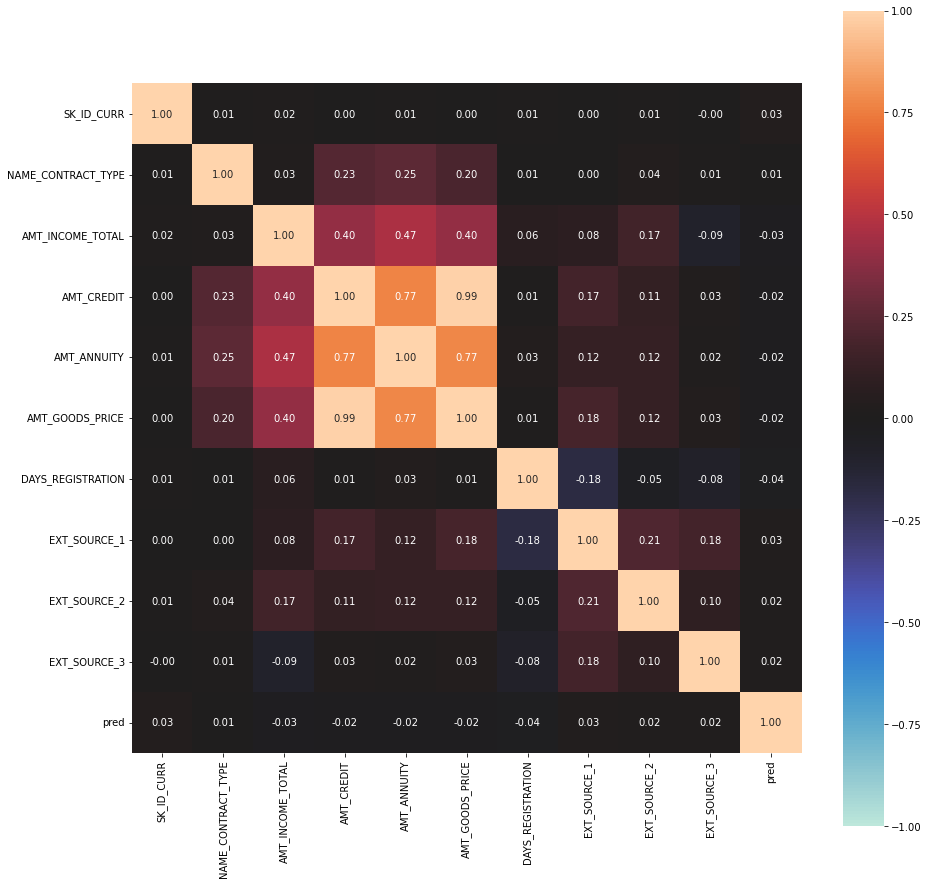

In [92]:
xgb_base_test_results_noethics = pd.DataFrame(xgb_base_test_results_noethics, columns = ['pred'])

test_correlation = pd.concat([test_noethics, xgb_base_test_results_noethics],
                             axis = 1)
complete_correlation = associations(test_correlation, nan_strategy = 'drop_samples', figsize=(15, 15))

After removing the ethical variable the relationship between the variables and the predictions undergoes some changes. One can see how in a model without ethical variables, it is difficult to find a significant correlation value between the predictions and the variables. 

# **[#9] Can you explain why just removing the variables wasn’t enough?**
*The ninth step regards an in-depth understanding of how model performs.*

Previous results were not as expected, it seems that dropping the ethical variable does not affect the performance of the model. It must therefore be noted that: 
- whether the ethical variables are altered individually, the change in the AUC depends on the weight of that variable in the model;
- whether the ethical variables are altered all at once, the AUC can change considerably;
- whether the ethical variables are dropped individually , the AUC decrease is not significant;
- whther the ethical variables are dropped individually, the AUC decreases but not by as much as one would expect. 



# **[#10] Hints at a possible (but questionable!) solution**
*The last task will focus on reflection about the problem and possible developments.*